In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys

In [4]:
import os
import nibabel as nib
import numpy as np
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.segment.mask import median_otsu
from dipy.segment.mask import applymask
from dipy.segment.mask import bounding_box
from dipy.segment.mask import crop

In [5]:
from dipy.viz import regtools
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)

### Visualisation Function

In [9]:
def plot_chart(scan1, scan2, scan3, scan4, sagital=0, coronal=0, axial=0):
    plt.figure
    plt.figure(figsize=(8,8))
    plt.subplot(3,4,1).set_axis_off()
    plt.imshow(scan1[:, :, axial, 0].T, cmap='gray', origin='lower')
    plt.title("Scan 1 PET")
    plt.subplot(3,4,2).set_axis_off()
    plt.imshow(scan2[:, :, axial, 0].T, cmap='gray', origin='lower')
    plt.title("Scan 2 PET")
    plt.subplot(3,4,3).set_axis_off()
    plt.imshow(scan3[:, :, axial, 0].T, cmap='gray', origin='lower')
    plt.title("Scan 1 TRIO")
    plt.subplot(3,4,4).set_axis_off()
    plt.imshow(scan4[:, :, axial, 0].T, cmap='gray', origin='lower')
    plt.title("Scan 2 TRIO")
    plt.subplot(3,4,5).set_axis_off()
    plt.imshow(scan1[sagital, :, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3,4,6).set_axis_off()
    plt.imshow(scan2[sagital, :, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3,4,7).set_axis_off()
    plt.imshow(scan3[sagital, :, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3,4,8).set_axis_off()
    plt.imshow(scan4[sagital, :, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3,4,9).set_axis_off()
    plt.imshow(scan1[:, coronal, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3,4,10).set_axis_off()
    plt.imshow(scan2[:, coronal, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3,4,11).set_axis_off()
    plt.imshow(scan3[:, coronal, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3,4,12).set_axis_off()
    plt.imshow(scan4[:, coronal, :, 0].T, cmap='gray', origin='lower')

# Functions for performing affine transformation

In [5]:
def affine_registration(scan1, scan1_grid2world, scan2, scan2_grid2world):
    #get first b0 volumes for both scans
    scan1_b0 = scan1[:,:,:,0]
    scan2_b0 = scan2[:,:,:,0]
    
    #In this function we use multiple stages to register the 2 scans
    #providng previous results as initialisation to the next stage, 
    #the reason we do this is because registration is a non-convex 
    #problem thus it is important to initialise as close to the 
    #optiaml value as possible
    
    #Stage1: we obtain a very rough (and fast) registration by just aligning 
    #the centers of mass of the two images
    
    center_of_mass = transform_centers_of_mass(scan1_b0, scan1_grid2world, scan2_b0, scan2_grid2world)
    
    #create the similarity metric (Mutual Information) to be used:
    nbins = 32
    sampling_prop = None #use all voxels to perform registration
    metric = MutualInformationMetric(nbins, sampling_prop)
    
    #We use a multi-resolution stratergy to accelerate convergence and avoid
    #getting stuck at local optimas (below are the parameters)
    level_iters = [10000, 1000, 100]
    sigmas = [3.0, 1.0, 0.0] #parameters for gaussian kernel smoothing at each resolution
    factors = [4, 2, 1] #subsampling factor
    
    #optimisation algorithm used is L-BFGS-B
    affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)
    
    #Stage2: Perform a basic translation transform
    transform = TranslationTransform3D()
    translation = affreg.optimize(scan1_b0, scan2_b0, transform, None, scan1_grid2world, scan2_grid2world, starting_affine=center_of_mass.affine)
    
    #Stage3 : optimize previous result with a rigid transform
    #(Includes translation, rotation)
    transform = RigidTransform3D()
    rigid = affreg.optimize(scan1_b0, scan2_b0, transform, None, scan1_grid2world, scan2_grid2world, starting_affine=translation.affine)
    
    #Stage4 : optimize previous result with a affine transform
    #(Includes translation, rotation, scale, shear)
    transform = AffineTransform3D()
    affine = affreg.optimize(scan1_b0, scan2_b0, transform, None, scan1_grid2world, scan2_grid2world, starting_affine=rigid.affine)
    
    
    #Once this is completed we can perform the affine transformation on each 
    #volume of scan2
    
    for volume in range(0, scan2.shape[3]):
        #note affine is an AffineMap object,
        #The transform method transforms the input image from co-domain to domain space
        #By default, the transformed image is sampled at a grid defined by the shape of the domain
        #The sampling is performed using linear interpolation (refer to comp vision lab on homographies)
        scan2[:,:,:,volume] = affine.transform(scan2[:,:,:,volume])
        
    return scan2
    

In [6]:
def compute_masks_crop(petmr_scan1, petmr_scan2, trio_scan1, trio_scan2):
    #Median_otsu is a segmnentation technique that is a hybridisation of median filtering and otsu thresholding
    #the combination (4,4) is shown to be the most robust
    _, petmr_scan1_mask = median_otsu(petmr_scan1, median_radius=4, numpass=4, autocrop=False, dilate=2)
    _, petmr_scan2_mask = median_otsu(petmr_scan2, median_radius=4, numpass=4, autocrop=False, dilate=2)
    _, trio_scan1_mask = median_otsu(trio_scan1, median_radius=4, numpass=4, autocrop=False, dilate=2)
    _, trio_scan2_mask = median_otsu(trio_scan2, median_radius=4, numpass=4, autocrop=False, dilate=2)
    
    #Get the union of the masks
    mask_union = np.logical_and(np.logical_and(petmr_scan1_mask, petmr_scan2_mask), np.logical_and(trio_scan1_mask, trio_scan2_mask))
    
    #Apply the unoioned mask to the scans
    petmr_scan1_brain = applymask(petmr_scan1, mask_union)
    petmr_scan2_brain = applymask(petmr_scan2, mask_union)
    trio_scan1_brain = applymask(trio_scan1, mask_union)
    trio_scan2_brain = applymask(trio_scan2, mask_union)
    
    #Crop the scans using the unioned mask
    (mins, maxs) = bounding_box(mask_union)
    petmr_scan1_brain = crop(petmr_scan1_brain, mins, maxs)
    petmr_scan2_brain = crop(petmr_scan2_brain, mins, maxs)
    trio_scan1_brain = crop(trio_scan1_brain, mins, maxs)
    trio_scan2_brain = crop(trio_scan2_brain, mins, maxs)
    
    return (petmr_scan1_brain, petmr_scan2_brain, trio_scan1_brain, trio_scan2_brain)  

In [29]:
def perform_registration(dataset_path_petmr, dataset_path_trio, dataset_path_store_petmr, dataset_path_store_trio):
    os.chdir(dataset_path_store_trio)
    #iterate through the subjects in the directory
    subj_scans = os.listdir(os.getcwd())[1:]
    for scan in range(0, (len(subj_scans)/2)):
        print ("Processing %s and %s (PETMR and TRIO scans)" % (str(subj_scans[(scan*2)]), str(subj_scans[(scan*2)+1])))
        #load all 4 scans of a subject (images) 
        petmr_scan1 = nib.load(str(dataset_path_store_petmr) + "/" + str(subj_scans[(scan*2)]) + "/NODDI_3Shells.nii.gz")
        trio_scan1 = nib.load(str(dataset_path_store_trio) + "/" + str(subj_scans[(scan*2)]) + "/NODDI_3Shells.nii.gz")
        petmr_scan2 = nib.load(str(dataset_path_store_petmr) + "/" + str(subj_scans[(scan*2)+1]) + "/NODDI_3Shells.nii.gz")
        trio_scan2 = nib.load(str(dataset_path_store_trio) + "/" + str(subj_scans[(scan*2)+1]) + "/NODDI_3Shells.nii.gz")
        
        #Convert the images to dipy format
        petmr_scan1_data = petmr_scan1.get_data()
        trio_scan1_data = trio_scan1.get_data()
        petmr_scan2_data = petmr_scan2.get_data()
        trio_scan2_data = trio_scan2.get_data()
        
        #get the grid2world matrices for each scan
        petmr_scan1_grid2world = petmr_scan1.affine
        trio_scan1_grid2world = trio_scan1.affine
        petmr_scan2_grid2world = petmr_scan2.affine
        trio_scan2_grid2world = trio_scan2.affine
        
        #perform registration using petmr scan1 as the static/reference scan
        #i.e we apply spatial transformations to all other scans to achive spatial correspondance with scan 1
        #by doing so we indirectly achive spatial correspondace between all scans
        print ("Performing Registration for: PETMR scan2")
        petmr_scan2_transformed = affine_registration(petmr_scan1_data, petmr_scan1_grid2world, petmr_scan2_data, petmr_scan2_grid2world)
        print ("Performing Registration for: TRIO scan1")
        trio_scan1_transformed = affine_registration(petmr_scan1_data, petmr_scan1_grid2world, trio_scan1_data, trio_scan1_grid2world)
        print ("Performing Registration for: TRIO scan2")
        trio_scan2_transformed = affine_registration(petmr_scan1_data, petmr_scan1_grid2world, trio_scan2_data, trio_scan2_grid2world)
        print ("---Registration Completed---")
        
        
        #Compute brain masks for each scan
        print ("Computing brain masks")
        (petmr_scan1_brain, petmr_scan2_brain, trio_scan1_brain, trio_scan2_brain) = \
        compute_masks_crop(petmr_scan1_data, petmr_scan2_transformed, trio_scan1_transformed, trio_scan2_transformed)
        
        #save the new masked/cropped scans
        print ("Saving the masks")
        petmr_scan1_img = nib.Nifti1Image(petmr_scan1_brain.astype(np.float32), petmr_scan1.affine)
        nib.save(petmr_scan1_img, str(dataset_path_petmr)+ "/" + str(subj_scans[(scan*2)]) + "/Brain_Extracted.nii.gz" )
        
        petmr_scan2_img = nib.Nifti1Image(petmr_scan2_brain.astype(np.float32), petmr_scan1.affine)
        nib.save(petmr_scan2_img, str(dataset_path_petmr)+ "/" + str(subj_scans[(scan*2)+1]) + "/Brain_Extracted.nii.gz" )
        
        trio_scan1_img = nib.Nifti1Image(trio_scan1_brain.astype(np.float32), petmr_scan1.affine)
        nib.save(trio_scan1_img, str(dataset_path_trio)+ "/" + str(subj_scans[(scan*2)]) + "/Brain_Extracted.nii.gz" )
        
        trio_scan2_img = nib.Nifti1Image(trio_scan2_brain.astype(np.float32), petmr_scan1.affine)
        nib.save(trio_scan2_img, str(dataset_path_trio)+ "/" + str(subj_scans[(scan*2)+1]) + "/Brain_Extracted.nii.gz" )
        print ("---Iteration Complete---")

----------------------------------------------------------------------------------------------------------
---

----------------------------------------------------------------------------------------------------------
---

# With automated functions

In [30]:
dataset_path_trio = '/Users/ShivamDhall/Desktop/Project/Dataset/TRIO_data'
dataset_path_petmr = '/Users/ShivamDhall/Desktop/Project/Dataset/PETMR_data'
dataset_path_store_petmr = '/Volumes/Seagate Backup Plus Drive/Project/PETMR_data'
dataset_path_store_trio = '/Volumes/Seagate Backup Plus Drive/Project/TRIO_data_organised'
perform_registration(dataset_path_petmr, dataset_path_trio, dataset_path_store_petmr, dataset_path_store_trio)

Processing Subj10Scan1 and Subj10Scan2 (PETMR and TRIO scans)
Performing Registration for: PETMR scan2
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Performing Registration for: TRIO scan1
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Performing Registration for: TRIO scan2
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max 

## Check results

In [15]:
os.chdir('/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data/Subj1Scan1/')
imgScan1 = nib.load("Brain_Extracted.nii.gz")
petmr_scan1 = imgScan1.get_data()

os.chdir('/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data/Subj1Scan2/')
imgScan2 = nib.load("Brain_Extracted.nii.gz")
petmr_scan2 = imgScan2.get_data()

os.chdir('/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data/Subj1Scan1/')
imgScan3 = nib.load("Brain_Extracted.nii.gz")
trio_scan1 = imgScan3.get_data()

os.chdir('/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data/Subj1Scan2/')
imgScan4 = nib.load("Brain_Extracted.nii.gz")
trio_scan2 = imgScan4.get_data()

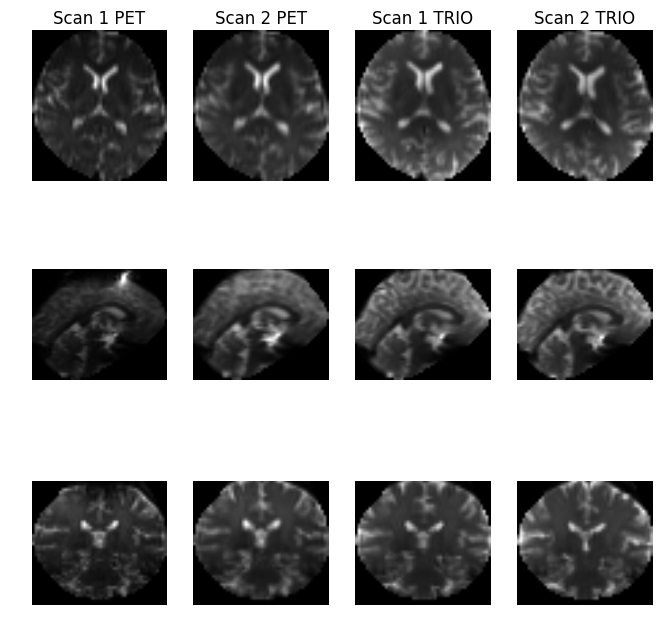

In [22]:
plot_chart(petmr_scan1, petmr_scan2, trio_scan1, trio_scan2, 25, 25, 25)

In [23]:
print petmr_scan1.shape
print petmr_scan2.shape
print trio_scan1.shape
print trio_scan2.shape

(50, 56, 46, 117)
(50, 56, 46, 117)
(50, 56, 46, 117)
(50, 56, 46, 117)
